<a href="https://www.kaggle.com/gazu468/nbme-details-eda?scriptVersionId=89473544" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

###  Please Upvote this Notebook if find anything important.

In this competition, you’ll identify specific clinical concepts in patient notes. Specifically, you'll develop an automated method to map clinical concepts from an exam rubric (e.g., “diminished appetite”) to various ways in which these concepts are expressed in clinical patient notes written by medical students (e.g., “eating less,” “clothes fit looser”). Great solutions will be both accurate and reliable.

## Import all those Library

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
import re

## - Import dataset

In [2]:
train =pd.read_csv('../input/nbme-score-clinical-patient-notes/train.csv')
patiens_note = pd.read_csv('../input/nbme-score-clinical-patient-notes/patient_notes.csv')
features = pd.read_csv('../input/nbme-score-clinical-patient-notes/features.csv')
test= pd.read_csv('../input/nbme-score-clinical-patient-notes/test.csv')

### Train CSV
Feature annotations for 1000 of the patient notes, 100 for each of ten cases.
- `id` - Unique identifier for each patient note / feature pair.
- `pn_num `- The patient note annotated in this row.
- `feature_num `- The feature annotated in this row.
- `case_num` - The case to which this patient note belongs.
- `annotation` - The text(s) within a patient note indicating a feature. A feature may be indicated multiple times within a single note.
- `location` - Character spans indicating the location of each annotation within the note. Multiple spans may be needed to represent an annotation, in which case the spans are delimited by a semicolon

In [3]:
#check train columns
train.columns

Index(['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location'], dtype='object')

In [4]:
#row and columns of train data
train.shape

(14300, 6)

In [5]:
#chek null value
train.isnull().sum().sum()

0

### Discuss about Patience Note 

In [6]:
#view from patience note
patiens_note.head(5)

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...


In [7]:
patiens_note.shape

(42146, 3)

### Value counts from Each Cases

In [8]:
#value counts
temp = patiens_note.groupby('case_num').count()['pn_history'].reset_index().sort_values(by='pn_history', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,pn_history
3,3,9753
5,5,6909
4,4,5405
9,9,5151
8,8,4196
7,7,4101
0,0,2268
2,2,1958
6,6,1597
1,1,808


<AxesSubplot:xlabel='case_num', ylabel='count'>

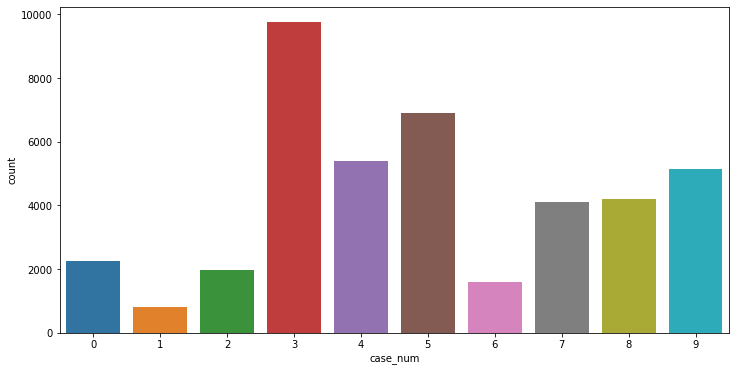

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='case_num', data=patiens_note)

In [10]:
fig=go.Figure(go.Funnelarea(
    text=temp.case_num,
    values=temp.pn_history,
    title= {"position":"top center", "text": "Funnel-chart on Case Number Distribution"}))
fig.show()

### Most Common word 

In [11]:
#Most common word in the target Selected
patiens_note['temp']= patiens_note['pn_history'].apply(lambda x: str(x).split())
top= Counter([item for sublist in patiens_note['temp'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns=["Common_words", 'count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,and,134345
1,with,95369
2,of,92239
3,no,82617
4,a,75820
5,the,70754
6,in,70346
7,has,68659
8,is,62703
9,for,57314


In [12]:
fig = px.bar(temp,x="count", y="Common_words", 
             title="Common words in Selected Text", orientation='h', width=700, height=700,color='Common_words')
fig.show()

### Remove Stop words and check common word again

In [13]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
patiens_note['temp'] = patiens_note['temp'].apply(lambda x: remove_stopword(x))

In [14]:
top = Counter([item for sublist in patiens_note['temp'] for item in sublist])
temp=pd.DataFrame(top.most_common(20))
temp=temp.iloc[1:,:]
temp.columns=["Common_words",'count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,pain,40083
2,2,38697
3,No,35750
4,none,33490
5,denies,30296
6,-,22866
7,last,22159
8,3,21139
9,weeks,20609
10,PMH:,19741


In [15]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common words')
fig.show()

### Most common word in  most popular case 

In [16]:
most_popular_case = patiens_note[patiens_note['case_num']==3]

In [17]:
#MosT common  words in 
top = Counter([item for sublist in most_popular_case['temp'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,pain,26939
1,2,13638
2,He,13548
3,No,9174
4,back,7629
5,35,7509
6,epigastric,6950
7,none,6402
8,pain.,6201
9,denies,6157


In [18]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Words popular cases Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

### Sample of Patience Note

In [19]:
print(patiens_note["pn_history"].iloc[15])

Mr. Cleveland is a 17 yo male who presents today for 2-3 history of heart pounding episodes. Has had 5-6 epidosdes total that last 3-4 minutes. Usually just heart pounding but most recent episode accompanied by SOB, chest pressure in center of chest, and lightheadedness. Was watching TV when last epidose happened. Random time of day. Nothing makes better or worse.
PMH: healthy
Medications: roommates aderol
allergies: none
PSH: None
FH: Father living but had MI last year. Mother has not otherwise specified thyroid problem. No history of sudden cardiac death.
SH: NO smoking, 3-4 beer on weekened night, occassional marajuana use, student, relationships with friends and family are goood. No streess. No anxiety. 
ROS: Postivie: Palpitations, SOB, chest pressure, lightheadedness with episodes
Negative: headaches, vision changes, weight loss, heat intolerance, nausea vomiting, changes in bowel or bladder function, abdominal pain. 



### Distribution of top n-grams for pn_history

In [20]:
# if n_words=1 -> unigrams, if n_words=2 -> bigrams..
def get_top_Nwords(corpus, n=None, remove_stop_words=False, n_words=1):
    if remove_stop_words:
        vec = CountVectorizer(stop_words='english', ngram_range=(n_words, n_words)).fit(corpus)
    else:
        vec = CountVectorizer(ngram_range=(n_words, n_words)).fit(corpus)
    
    bag_ofWords =vec.transform(corpus)
    sum_words = bag_ofWords.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

### Bigram distribution

In [21]:
common_words = get_top_Nwords(patiens_note['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=2)
for word, freq in common_words:
    print(word, freq)

sexually active 16461
weeks ago 14173
chest pain 12695
months ago 11170
drug use 10382
ros negative 9517
pmh psh 8969
year old 8922
nausea vomiting 6939
35 yo 6192
abdominal pain 6062
allergies nkda 5925
past weeks 5523
years ago 5377
weight loss 5272
falling asleep 5148
epigastric pain 5012
old female 4676
breast cancer 4672
active boyfriend 4612


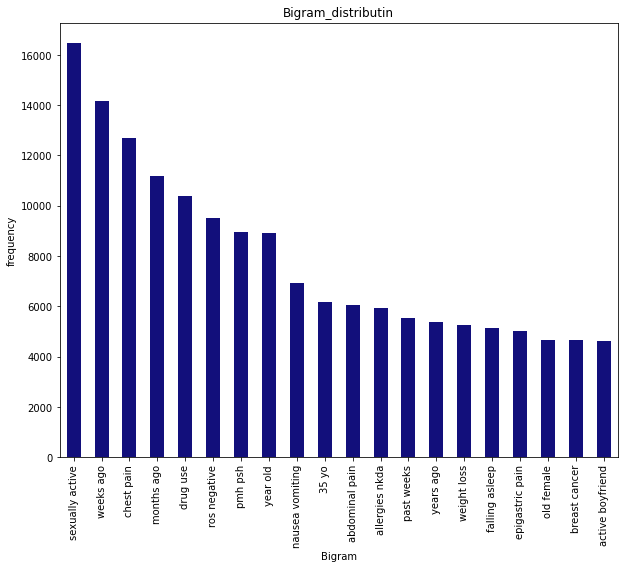

In [22]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Bigram_distributin")
ax1.set_xlabel('Bigram')
ax1.set_ylabel("frequency")
plt.show()

### Tigram distribution

In [23]:
common_words = get_top_Nwords(patiens_note['pn_history'].drop_duplicates(), 20, remove_stop_words=True, n_words=3)
for word, freq in common_words:
    print(word, freq)

year old female 4388
sexually active boyfriend 4242
illicit drug use 3540
uncle bleeding ulcer 3413
ros negative pmh 3362
sexually active husband 2878
35 year old 2872
difficulty falling asleep 2853
pmh psh meds 2584
lmp weeks ago 2265
year old male 2173
chest pain sob 1990
use sexually active 1947
drugs sexually active 1893
fh uncle bleeding 1788
denies chest pain 1781
pmh psh fh 1745
15 30 minutes 1657
drug use sexually 1607
mr hamilton 35 1476


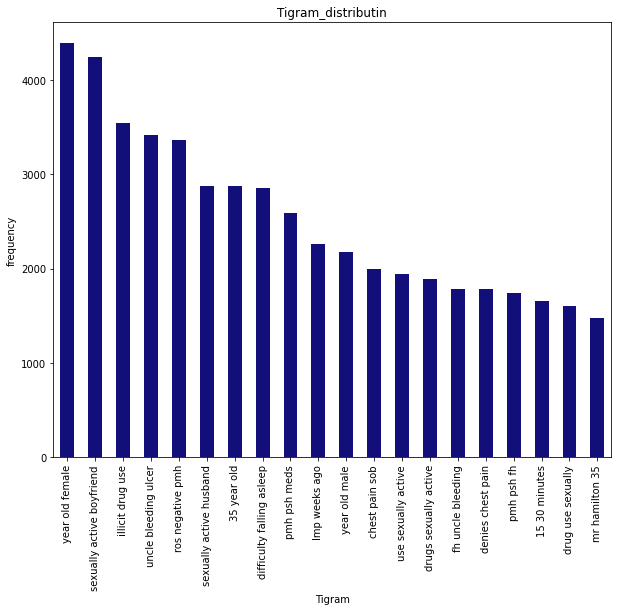

In [24]:
train_temp =pd.DataFrame(common_words, columns=['text', 'count'])
fig = plt.figure(figsize=(10,8))
ax1 = train_temp.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar',
                                                                            color='#120f7b')
ax1.set_title("Tigram_distributin")
ax1.set_xlabel('Tigram')
ax1.set_ylabel("frequency")
plt.show()

Hey, why not we check the wordcloud for better observation.
### WordCloud

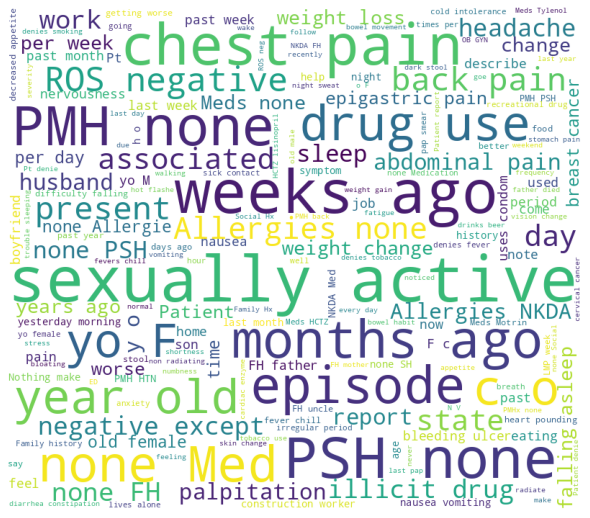

In [25]:
stopwords=set(STOPWORDS)
wordclouds=WordCloud(width=800, 
                    height=700,
                    background_color='white',
                    max_font_size=120,
                    min_font_size=10,
                    stopwords=stopwords).generate(''.join(patiens_note['pn_history']))

#plot the worldcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordclouds)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [26]:
def pre_processing_text(text, flg_steam=False,flg_lemm=True):
    #lower case
    text=re.sub(r'[^\w\s]','',str(text).lower().strip())
    #tokenize
    words = text.split()
    #stop steamming
    if flg_steam==True:
        ps=nltk.stem.porter.PorterStemmer()
        words = [ps.stem(word) for word in words]
    #lemmitization
    if flg_lemm == True:
        lem=nltk.stem.wordnet.WordNetLemmatizer()
        words = [lem.lemmatize(word) for word in words]
    
    #back to string from list
    text = ' '.join(words)
    return text
        

In [27]:
# length of pn_history
patiens_note['clean_history']=patiens_note['temp'].apply(lambda x: pre_processing_text(x,
                                                                                       flg_steam=False, flg_lemm=True))

In [28]:
#clean word count
patiens_note['clean_word']=patiens_note['clean_history'].apply(lambda x: len(x))
patiens_note['word_count'] = patiens_note['clean_history'].apply(lambda x: len(str(x).split(" ")))

In [29]:
def plot_distribution(x, title):
    fig=px.histogram(patiens_note['pn_history'],
                    x=x,
                    width=800,
                    height=500,
                    title=title)
    fig.show()

In [30]:
plot_distribution(x=patiens_note['clean_word'], title='Patience Note length')

In [31]:
plot_distribution(x=patiens_note['word_count'], title='Patience Note Word Count')

- Lets do some stuff on Features data.
## Features dataset and that view

In [32]:
features.head(5)

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


In [33]:
features_note = features.groupby("case_num").count()
fig = px.bar(data_frame =features_note, 
             x = features_note.index,
             y = 'feature_num' , 
             color_discrete_sequence=['#D63230'],
             orientation='h',
             color_continuous_scale="Emrld")
fig.show()

### Value count in Features

In [34]:
temp = features.groupby('case_num').count()['feature_text'].reset_index().sort_values(by='feature_text', ascending=False)
temp.style.background_gradient(cmap='Purples')

,case_num,feature_text
5,5,18
8,8,18
2,2,17
9,9,17
3,3,16
0,0,13
1,1,13
6,6,12
4,4,10
7,7,9


In [35]:
fig=go.Figure(go.Funnelarea(
    text=temp.case_num,
    values=temp.feature_text,
    title= {"position":"top center", "text": "Funnel-chart on Case Number Distribution"}))
fig.show()

### WordCloud

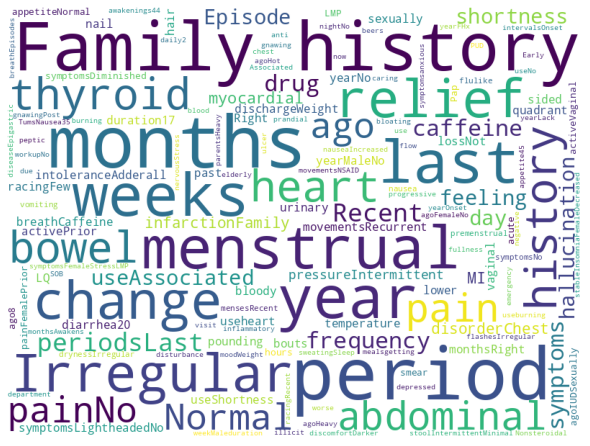

In [36]:
stopwords=set(STOPWORDS)
wordclouds=WordCloud(width=800, 
                    height=600,
                    max_font_size=100,
                    background_color='white',
                    min_font_size=10,
                    stopwords=stopwords).generate(''.join(features['feature_text']))

#plot the worldcloud image
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordclouds)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Thanks for checking this notebook. If you have any query please feel free to ask and also suggest me if you have. Don't forget to support me. :-)